- Claim, "you would like this restaurant"
- Evidence, "Cause you used to like A and B aspects" (based on the importance on aspects)
- Evidence, "Similar users also visited this restaurant"

In [1]:
import pandas as pd;
import numpy as np;
from collections import defaultdict;
from nltk.stem.wordnet import WordNetLemmatizer;
lemma = WordNetLemmatizer();

In [2]:
restaurants = pd.read_parquet('restaurants_reviews_with_aspects_polarities');
users = pd.read_parquet('users_reviews_with_aspects_polarities');

In [3]:
# duplicate the aspect polarity pair if the useful field is not 0
restaurants['aspect_polarity'] = restaurants.apply(lambda x: np.repeat(x['aspect_polarity'], x['useful']+1), axis=1);

In [4]:
users_test = {};

user_ids = users['user_id'].unique();
for user_id in user_ids:
    user_df = users.groupby('user_id').get_group(user_id);
    mask_restaurants = pd.Series(user_df[user_df['stars'] >= 3]['business_id'].unique()).sample(frac=0.2, random_state=100).values;
    users_test[user_id] = mask_restaurants;

In [5]:
users_train = users.copy();

for user_id in users_test:
    user = users_test[user_id];
    for restaurant_id in user:
        drop_rows = users_train[(users_train['user_id'] == user_id)&(users_train['business_id'] == restaurant_id)];
        users_train.drop(drop_rows.index, inplace=True);

In [6]:
users_visited = {};

for user_id in user_ids:
    users_visited[user_id] = users_train.groupby('user_id').get_group(user_id)['business_id'].unique();

### Compute the scores of aspects  

Format for aspect: [Overall score = POS-NEG, Positive CNT, Negative CNT, Total CNT=POS+NEG+NEUTRAL]

In [7]:
def getScore(sentiment):
    if sentiment == 'Positive':
        return 1;
    elif sentiment == 'Negative':
        return -1;
    else:
        return 0;

def reviewAspects(dic):
    def inner(aspect_polarity_pairs):
        for pair in aspect_polarity_pairs:
            aspects, sentiments = pair['aspect'], pair['sentiment'];
            for i, aspect in enumerate(aspects):
                aspect = lemma.lemmatize(lemma.lemmatize(aspect, pos='v'), pos='n');
                dic[aspect][0] += getScore(sentiments[i]);
                if sentiments[i] == 'Positive':
                    dic[aspect][1] += 1;
                if sentiments[i] == 'Negative':
                    dic[aspect][2] += 1;
                dic[aspect][3] += 1;
    return inner;

In [8]:
# Get the aspects and score of them of restaurants
restaurant_aspects = {};
for business in restaurants['business_id'].unique():
    dic = defaultdict(lambda: [0, 0, 0, 0]);
    restaurants.groupby('business_id').get_group(business)['aspect_polarity'].apply(reviewAspects(dic));
    # dic = sorted(dic.items(), key=lambda x: x[1], reverse=True);
    restaurant_aspects[business] = dic;

In [9]:
# Get the aspects and score of them of users
user_aspects = {};
for user in users_train['user_id'].unique():
    dic = defaultdict(lambda: [0, 0, 0, 0]);
    users_train.groupby('user_id').get_group(user)['aspect_polarity'].apply(reviewAspects(dic));
    # dic = sorted(dic.items(), key=lambda x: x[1], reverse=True);
    user_aspects[user] = dic;

In [10]:
REST_DICTIONARY = set();
for dic in restaurant_aspects.values():
    for key in dic:
        REST_DICTIONARY.add(key);

USER_DICTIONARY = set();
for dic in user_aspects.values():
    for key in dic:
        USER_DICTIONARY.add(key);
        
user_dictionary = list(USER_DICTIONARY);
restaurant_dictionary = list(REST_DICTIONARY);

Since the word matrix is too spacy, we have to remove some infrequent words.

In [11]:
# Aspects set of each restaurant
restaurant_aspects_set = {};
for restaurant in restaurant_aspects:
    restaurant_aspects_set[restaurant] = set(restaurant_aspects[restaurant].keys());

# Aspects set of each user
user_aspects_set = {};
for user in user_aspects:
    user_aspects_set[user] = set(user_aspects[user].keys());    
    
# Count the frequency of each aspect shown in restaurants
aspect_restaurant_freq = defaultdict(int);
for aspect in restaurant_dictionary:
    
    for restaurant in restaurant_aspects_set:
        if aspect in restaurant_aspects_set[restaurant]:
            aspect_restaurant_freq[aspect] += 1;

# Count the frequency of each aspect shown in user reviews
aspect_user_freq = defaultdict(int);
for aspect in user_dictionary:
    for user in user_aspects_set:
        if aspect in user_aspects_set[user]:
            aspect_user_freq[aspect] += 1;

In [12]:
# Remove unfrequent aspect from dictionary to reduce the size of dictionary, so the matrix will not be too sparse
user_unfreq = np.array(list(aspect_user_freq.keys()))[np.array(list(aspect_user_freq.values())) == 1];
rest_unfreq = np.array(list(aspect_restaurant_freq.keys()))[np.array(list(aspect_restaurant_freq.values())) == 1];

for aspect in user_unfreq:
    USER_DICTIONARY.remove(aspect);

for aspect in rest_unfreq:
    REST_DICTIONARY.remove(aspect);

In [13]:
DICTIONARY = REST_DICTIONARY.union(USER_DICTIONARY);

# dictionary containing all the aspects
dictionary = list(DICTIONARY);
user_dictionary = list(USER_DICTIONARY);
restaurant_dictionary = list(REST_DICTIONARY);

---
### Importance of aspects

**Concern, requirements and importance**

Caculation of concern:  
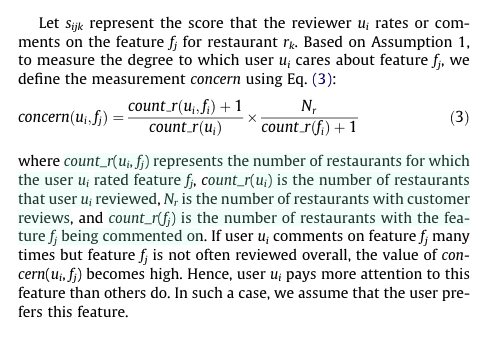

Caculation of requirement:   
NOTE: The calculation of requirements are unable to be finished, since we use the sentiment score but not rate from users.  
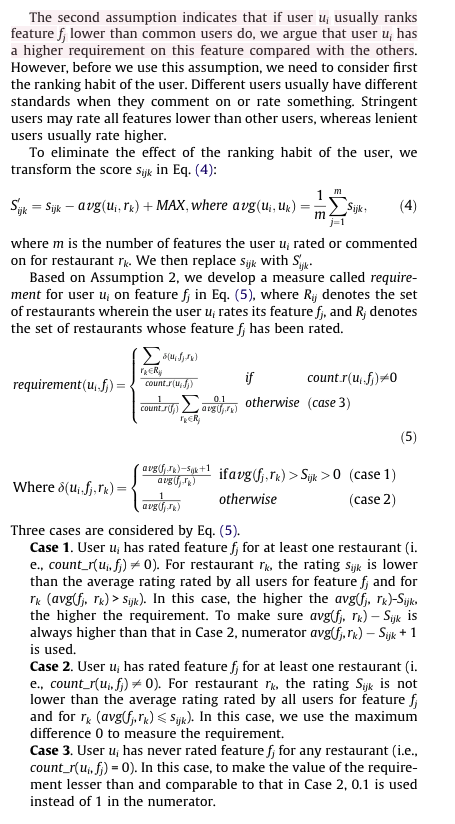

Importance  
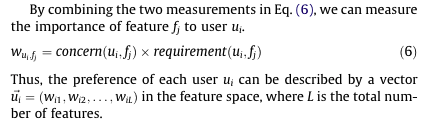

In [14]:
# Aspects set of each restaurant
restaurant_aspects_set = {};
for restaurant in restaurant_aspects:
    restaurant_aspects_set[restaurant] = set(restaurant_aspects[restaurant].keys());

# Count the frequency of each aspect shown in restaurants
aspect_restaurant_freq = defaultdict(int);
for aspect in restaurant_dictionary:
    for restaurant in restaurant_aspects_set:
        if aspect in restaurant_aspects_set[restaurant]:
            aspect_restaurant_freq[aspect] += 1;

In [15]:
user_concerns = {};
restaurants_total = restaurants['business_id'].unique().size;

for user_id in user_aspects.keys():
    user = user_aspects[user_id].copy();
    restaurants_visited = users_train.groupby('user_id').get_group(user_id)['business_id'].unique().size;
    for aspect in user:
        if aspect in restaurant_dictionary:
            user[aspect] = [((user[aspect][3]+1)/restaurants_visited)*np.log(restaurants_total/(aspect_restaurant_freq[aspect]+1)), user[aspect][3]];
        else: # if the aspect doesn't show in the restaurant_dictionary, assign 0
            user[aspect] = [0, user[aspect][3]];
        user = dict(sorted(user.items(), key=lambda x: x[1], reverse=True));
        user_concerns[user_id] = user;

In [33]:
AVG_USER_COMMENT_CNT = np.average([np.average([arr[3] for arr in user_aspects[user].values()]) for user in user_aspects]);
user_requirements = {};

for user in user_aspects:
    u_aspects = user_aspects[user].copy();
    res = {};
    for aspect in u_aspects:
        res[aspect] = u_aspects[aspect][2]/u_aspects[aspect][3] if u_aspects[aspect][3] > AVG_USER_COMMENT_CNT else 0; # user should mention an aspect at least twice
    user_requirements[user] = res;

In [34]:
user_importance = {};
for user_id in user_concerns:
    user_dict = {};
    user = user_concerns[user_id];
    for aspect in user:
        user_dict[aspect] = user[aspect][0]*(1+user_requirements[user_id][aspect]);
    user_dict = dict(sorted(user_dict.items(), key=lambda x: x[1], reverse=True));
    user_importance[user_id] = user_dict;

TODO: How to handling mistakes like 'desert' which is intended to be 'dessert'?

---
### Recommendation

In [27]:
dictionary_numpy = np.array(dictionary);

In [28]:
def userAspectToVector(uid, _aspects):
    aspects = _aspects[uid];
    vector = np.zeros(dictionary_numpy.size, dtype='object');
    for aspect, importance in aspects.items():
        if aspect in dictionary_numpy:
            index = np.where(dictionary_numpy==aspect)[0][0];
            vector[index] = importance;
    return np.insert(vector, 0, uid);

In [29]:
user_importances = pd.DataFrame(columns=np.insert(dictionary, 0, 'user_id'));
for user in user_importance:
    user_importances.loc[len(user_importances.index)] = userAspectToVector(user, user_importance);

In [30]:
user_importances_data = user_importances.to_numpy();
user_importances_data = np.delete(user_importances_data, 0, axis=1);

In [82]:
# AVG_RESTAURANT_COMMENT_CNT = np.average([np.average([arr[1] for arr in restaurant_aspects[restaurant].values()]) for restaurant in restaurant_aspects]);

def restaurantAspectToVector(rid, _aspects):
    aspects = _aspects[rid];
    vector = np.zeros(dictionary_numpy.size, dtype='object');
    for aspect, score in aspects.items():
        if aspect in dictionary_numpy:
            index = np.where(dictionary_numpy==aspect)[0][0];
            vector[index] = score[1] if score[1] >= 3 else 0;
            # vector[index] = score[1]/score[3] if score[1] >= 3 else 0;
    return np.insert(vector, 0, rid);

def restaurantAspectToVector2(rid, _aspects):
    aspects = _aspects[rid];
    vector = np.zeros(dictionary_numpy.size, dtype='object');
    for aspect, score in aspects.items():
        if aspect in dictionary_numpy:
            index = np.where(dictionary_numpy==aspect)[0][0];
            vector[index] = score[1];
    return np.insert(vector, 0, rid);

In [83]:
restaurant_scores = pd.DataFrame(columns=np.insert(dictionary, 0, 'r_id'));
for restaurant in restaurant_aspects:
    restaurant_scores.loc[len(restaurant_scores.index)] = restaurantAspectToVector(restaurant, restaurant_aspects);
    
restaurant_scores2 = pd.DataFrame(columns=np.insert(dictionary, 0, 'r_id'));
for restaurant in restaurant_aspects:
    restaurant_scores2.loc[len(restaurant_scores2.index)] = restaurantAspectToVector2(restaurant, restaurant_aspects);

In [84]:
restaurant_scores_data = restaurant_scores.to_numpy();
restaurant_scores_data = np.delete(restaurant_scores_data, 0, axis=1);

restaurant_scores_data_2 = restaurant_scores2.to_numpy();
restaurant_scores_data_2 = np.delete(restaurant_scores_data_2, 0, axis=1);

Compute the virtual score of a restaurant for target user by using both `aspect importance` and `the overall score of that aspect in specific restaurant`

In [85]:
user_restaurant_rs_scores = {};
user_ids = user_importances['user_id'].values;
restaurant_ids = restaurant_scores['r_id'].values;
get_value = lambda x: x[0];

for i in range(user_importances_data.shape[0]):
    scores = restaurant_scores_data*user_importances_data[i];
    rs_scores = [(np.sum(score), score) for score in scores];
    user_dict = dict(zip(restaurant_ids, rs_scores));
    user_dict = {k: v for k, v in sorted(user_dict.items(), key=lambda item: item[1][0], reverse=True)};
    r_visited = users_visited[user_ids[i]];
    for r in r_visited:
        user_dict.pop(r);
    user_restaurant_rs_scores[user_ids[i]] = user_dict;

user_restaurant_rs_scores_2 = {};
for i in range(user_importances_data.shape[0]):
    scores = restaurant_scores_data_2*user_importances_data[i];
    rs_scores = [(np.sum(score), score) for score in scores];
    user_dict = dict(zip(restaurant_ids, rs_scores));
    user_dict = {k: v for k, v in sorted(user_dict.items(), key=lambda item: item[1][0], reverse=True)};
    r_visited = users_visited[user_ids[i]];
    for r in r_visited:
        user_dict.pop(r);
    user_restaurant_rs_scores_2[user_ids[i]] = user_dict;

In [163]:
def analyseScores(scores):
    dic = dict(zip(dictionary_numpy, scores));
    return {k: v for k, v in sorted(dic.items(), key=lambda item: item[1], reverse=True)};

def getTestSetOf(uid):
    df = pd.DataFrame(columns=users.columns);
    visited = users_test[uid];
    for rid in visited:
        df = pd.concat([df, users.groupby(['user_id', 'business_id']).get_group((uid, rid))]);
    return df;

def sortRestaurantAspect(rid):
    return {k: v for k, v in sorted(restaurant_aspects[rid].items(), key=lambda x: x[1][0], reverse=True)}

def existAspect(a_s_pairs, target):
    for a_s_pair in a_s_pairs:
        aspects = a_s_pair['aspect'];
        for aspect in aspects:
            if target in lemma.lemmatize(lemma.lemmatize(aspect, pos='v'), pos='n'): return True
    return False

def getReviewWithAspect(rid, aspect):
    r_df = restaurants[restaurants['business_id'] == rid];
    res = [];
    for index, r_review in r_df.iterrows():
        if existAspect(r_review['aspect_polarity'], aspect):
                res.append(index);
    return r_df.loc[res];

#### Analysis example

Select a user and it's recommend results and analyse it.

In [167]:
selected_user = user_ids[1];
top_1_rest = list(user_restaurant_rs_scores[selected_user].keys())[0];

In [168]:
list(analyseScores(user_restaurant_rs_scores[selected_user][top_1_rest][1]).items())[:10]

[('pizza', 312.7415683777433),
 ('crust', 8.331208017305931),
 ('pie', 7.932056122617932),
 ('cheese', 5.847673653557674),
 ('beer', 2.227084437334446),
 ('owner', 1.6329422450912434),
 ('mozzarella cheese', 1.5147650940556239),
 ('slice', 1.4592585757086034),
 ('wait', 0.9564514711959863),
 ('ingredient', 0.8634931471531769)]

In [169]:
list(user_importance[selected_user])[:10]

['aioli',
 'truffle oil',
 'pizza',
 'bagel',
 'lobster mac',
 'fish',
 'sprout',
 'calamari',
 'taco',
 'chip']

- Manually check whether aspect appear in the test set.
- Diagram to explain the argumentation
- Combine different argumentation schemes to create a restaurant recommendation argumentation scheme

### Evaluation

In [ ]:
POS_CNT, NEG_CNT = 0, 0;
for uid, rids in users_test.items():
    POS_CNT += np.sum(getTestSetOf(uid)['stars'] >= 3);
    NEG_CNT += np.sum(getTestSetOf(uid)['stars'] < 3);
TOTAL_CNT = POS_CNT+NEG_CNT;

TOTAL_CNT, POS_CNT, NEG_CNT

In [ ]:
PT_CNT = 0;
PF_CNT = 0;
NT_CNT = 0;
NF_CNT = 0;

for uid in user_ids:
    test_set = getTestSetOf(uid);
    for index, row in test_set.iterrows():
        star, rid = row['stars'], row['business_id'];
        recommend_score = user_restaurant_rs_scores[uid][rid][0];
        if star >= 3:
            if recommend_score > 0:
                PT_CNT += 1;
            else:
                PF_CNT += 1;
        else:
            if recommend_score < 0:
                NT_CNT += 1;
            else:
                NF_CNT += 1;

(PT_CNT+NT_CNT)/TOTAL_CNT, (PF_CNT+NF_CNT)/TOTAL_CNT

In [ ]:
def restaurantTop10Aspects(rid):
    get_aspect = lambda x: x[0];
    top10_items = sorted(restaurant_aspects[rid].items(), key=lambda x: x[1][0], reverse=True)[:10];
    aspects = [get_aspect(item) for item in top10_items];
    return aspects;

def userTop10Aspects(uid):
    return list(user_importance[uid].keys())[:10];

count = 0;

for uid in user_ids:
    global count;
    u_top10 = userTop10Aspects(uid);
    rid = list(user_restaurant_rs_scores[uid].keys())[0];
    r_top10 = restaurantTop10Aspects(rid);
    for aspect in r_top10:
        if aspect in u_top10:
            count += 1;
            break;

count/100

#### Evaluation of place  
- Coverage  
    - Coverage is the percent of items in the training data the model is able to recommend on a test set. 
    - For the evaluation of place, recommendated place/visited place, the result is not good
- MAP@k  
    - http://sdsawtelle.github.io/blog/output/mean-average-precision-MAP-for-recommender-systems.html  
    - https://towardsdatascience.com/evaluation-metrics-for-recommender-systems-df56c6611093  
    MAP@k is somehow useless for this project, since we merely have negative reviews

In [43]:
def coverage_score(uids, recommend_scores):
    count = 0;
    for uid in uids:
        for rid in list(recommend_scores[uid].keys())[:users_test[uid].size]:
            if rid in users_test[uid]:
                count += 1;
                
    total_count = 0;
    for uid in users_test:
        total_count += users_test[uid].size;
    
    return count/total_count;

In [44]:
coverage_score(user_ids, user_restaurant_rs_scores), coverage_score(user_ids, user_restaurant_rs_scores_2)

(0.1203155818540434, 0.11834319526627218)

### Baseline traditional CF-RS

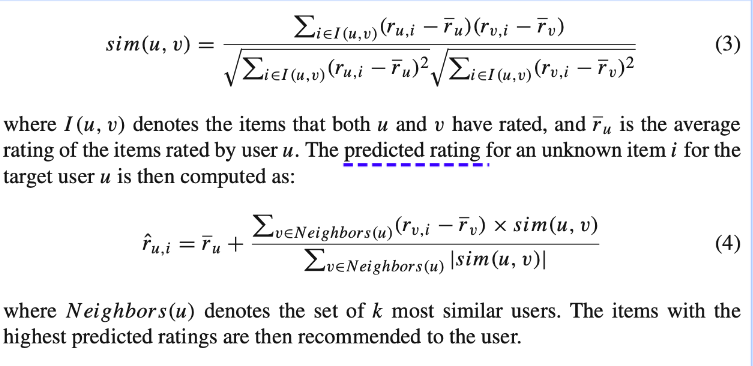

In [45]:
from numpy.linalg import norm;

In [46]:
restaurant_ids = restaurants['business_id'].unique();

In [47]:
def userRestaurantToVector(uid):
    visited_rids = users_visited[uid];
    vector = np.zeros(restaurant_ids.size, dtype='float');
    for visited_rid in visited_rids:
        index = np.where(restaurant_ids==visited_rid)[0][0];
        score = np.average(users_train.groupby(['user_id', 'business_id']).get_group((uid, visited_rid))['stars'].values);
        vector[index] = score;
    return vector;

In [48]:
user_rvector_matrix = np.array([userRestaurantToVector(uid) for uid in user_ids]);
user_similarity_matric = np.array([np.dot(user_rvector_matrix, user_rvector_matrix[i])/(norm(user_rvector_matrix, axis=1)*norm(user_rvector_matrix[i])) for i in range(100)]);

In [49]:
def getAverageScoreOf(uid):
    return np.average(users_train.groupby('user_id').get_group(uid)['stars'].values);

def getTop10NeighborsWithScore(vector):
    simialr_users = dict(zip(user_ids, vector));
    simialr_users = sorted(simialr_users.items(), key=lambda x: x[1], reverse=True);
    top_10_neighbors = list(simialr_users)[1:11];
    return top_10_neighbors;

def recommendScoreOf(uid, vector):
    top_10_neighbors = getTop10NeighborsWithScore(vector);
    avg_score_u = getAverageScoreOf(uid);
    rids = set(restaurant_ids).difference(set(users_visited[uid])); # Get the restaurants that haven't been visited by user u
    scores = {}
    
    for rid in rids:
        r_index = list(restaurant_ids).index(rid);
        numerator, denominator = 0, 0;
        for vid, similarity in top_10_neighbors:
            v_visited = users_visited[vid];
            v_index = list(user_ids).index(vid);
            if rid in v_visited:
                avg_score_v = getAverageScoreOf(vid);
                v_r_score = user_rvector_matrix[v_index][r_index];
                numerator += similarity*(v_r_score-avg_score_v);
                denominator += abs(similarity);
        scores[rid] = avg_score_u+(numerator/denominator) if denominator else 0; # 0 represents i doesn't appear in any of the neighbours's history
    
    return scores;

In [50]:
count = 0;

for i, uid in enumerate(user_ids):
    recommend_ids = [rid for rid, score in sorted(recommendScoreOf(uid, user_similarity_matric[i]).items(), key=lambda x: x[1], reverse=True)][:users_test[uid].size];
    for rid in recommend_ids:
        if rid in users_test[uid]:
            count += 1;

total_count = 0;
for uid in users_test:
    total_count += users_test[uid].size;

In [51]:
count/total_count

0.10059171597633136

---

### Variation: Cluster aspects into specific groups (Method 2)

IDEA: use word embedding from spacy to compute the cosine similarity between words

- Food
    - 'food', 'dessert', 'drink', 'dipping'
- Ambience
    - 'ambinece', 'decoration'
- Service
    - 'service', 'staff'
- Location

In [44]:
import spacy;
nlp = spacy.load("en_core_web_lg");

2022-08-25 07:09:16.773019: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-25 07:09:16.773048: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-25 07:09:20.571918: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-25 07:09:20.571952: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-25 07:09:20.571979: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist


In [45]:
dictionary_vector = np.array([nlp(word).vector for word in dictionary]);

In [46]:
dictionary_vector_norm = np.array([nlp(word).vector_norm for word in dictionary]);
dictionary_vector_norm = dictionary_vector_norm.reshape(-1, 1);

In [47]:
dictionary_vector_norm_matrix = np.dot(dictionary_vector_norm, dictionary_vector_norm.T);
dictionary_vector_matrix = np.dot(dictionary_vector, dictionary_vector.T);

In [48]:
similarity_matrix = dictionary_vector_matrix/dictionary_vector_norm_matrix
# Fill nan with 0
similarity_matrix = np.nan_to_num(similarity_matrix, nan=0);
similarity_matrix = np.around(similarity_matrix, 5);

/tmp/ipykernel_79/509002279.py:1: RuntimeWarning: invalid value encountered in true_divide
  similarity_matrix = dictionary_vector_matrix/dictionary_vector_norm_matrix


In [49]:
def distance(x, y):
    try:
        index_x, index_y = dictionary.index(x), dictionary.index(y);
        return 1-abs(similarity_matrix[index_x][index_y]);
    except:
        print('ERROR', x, y);
        return 2;

num = len(dictionary);
label = np.zeros(num);
dists = np.zeros(num);
for i in range(num):
    min_dist = 2; # The maximum distance bewtween two aspects is within 2, i.e. 1-(-1) = 2
    for j, keyword in enumerate(['food', 'dessert', 'drink', 'dipping',
                                  'decoration', 'ambience',
                                  'staff', 'service',
                                  'price',
                                  'location']):
        dist = distance(dictionary[i], keyword);
        if dist < min_dist:
            min_dist = dist;
            label[i] = j;
            dists[i] = dist;

ERROR carrot cake dipping
ERROR entrance dipping
ERROR polenta dipping
ERROR pastrami sandwich dipping
ERROR croissant dipping
ERROR price range dipping
ERROR appetizer menu dipping
ERROR counter space dipping
ERROR dumpling in chili dipping
ERROR beef tripe dipping
ERROR italian meal dipping
ERROR sink dipping
ERROR bonchon dipping
ERROR crabcakes dipping
ERROR potato dipping
ERROR curtain dipping
ERROR noodle dish dipping
ERROR egg white dipping
ERROR entrée dipping
ERROR customer service dipping
ERROR cheese flavor dipping
ERROR green bean casserole dipping
ERROR jim dipping
ERROR sea salt dipping
ERROR fee dipping
ERROR strawberry dipping
ERROR julep dipping
ERROR tortilla chip dipping
ERROR draft dipping
ERROR ravioli dipping
ERROR set dipping
ERROR brunch place dipping
ERROR brunch dish dipping
ERROR video dipping
ERROR content dipping
ERROR lo mein dipping
ERROR seafood pancake dipping
ERROR miso soup dipping
ERROR calorie dipping
ERROR energy dipping
ERROR honey butter dipping


In [50]:
dictionary = np.array(dictionary);

In [51]:
food_words = dictionary[label==0];
food_dists = dists[label==0];

In [52]:
food_words

array(['bonchon', 'sea salt', 'calorie', 'shop', 'al pastor taco', 'bos',
       'wild mushroom arancini', 'breast', 'trout', 'breakfast food',
       'xiandu', 'store', 'crabcake', 'decour', 'water', 'korean food',
       'food portion', 'popeyes', 'korean', 'black beans', 'valanni',
       'lump crab meat', 'mexican', 'food selection', 'moshulu', 'vedge',
       'food', 'pulpo', 'local beer', 'soy', 'genos', 'barbecue meat',
       'pickle vegetable', 'pig', 'finger food', 'corn beef', 'beef chow',
       'water pressure', 'pork fat', 'kanafeh', 'zavino', 'saad',
       'food item', 'white fish', 'buccatini', 'jamonera', 'suraya',
       'barbuzzo', 'fish tacos', 'wild boar taco', 'hunger', 'beef',
       'michelada', 'watercress', 'red meat', 'asian food', 'seafood',
       'humus', 'grain', 'mexican food', 'diner food', 'tehina',
       'butcher', 'takeout', 'quality of food', 'fairmount', 'smoke meat',
       'corn', 'sandwhiches', 'macaroni and cheese', 'home fry', 'hoagy',
     

In [53]:
beverage_words = dictionary[label==1];
beverage_dists = dists[label==1];

In [54]:
service_words = dictionary[label==2];
service_dists = dists[label==2];

In [55]:
price_words = dictionary[label==3];
price_dists = dists[label==3];

In [56]:
location_words = dictionary[label==4];
location_dists = dists[label==4];

In [57]:
ambience_words = dictionary[label==5];
ambience_dists = dists[label==5];

In [58]:
def similarity(a, b):
    return nlp(a).similarity(nlp(b));

In [59]:
similarity('ketchup', 'dessert'), similarity('ketchup', 'dipping')

(0.5272892623715159, 0.33097992310011537)

---

Convert aspects to vector and make clustering.

In [60]:
DICTIONARY = set();

for dic in restaurant_aspects.values():
    for key in dic:
        DICTIONARY.add(key);
        
for dic in user_aspects.values():
    for key in dic:
        DICTIONARY.add(key);
        
# dictionary containing all the user aspects
dictionary = np.array(list(DICTIONARY));

In [61]:
def aspect_to_vector(uid, _aspects):
    aspects = _aspects[uid];
    vector = np.zeros(len(dictionary), dtype='object');
    for aspect, scores in aspects.items():
        index = np.where(dictionary==aspect)[0][0];
        vector[index] = scores[0];
    return np.insert(vector, 0, uid);

In [62]:
user_df = pd.DataFrame(columns=np.insert(dictionary, 0, 'user_id'));
for user in user_aspects:
    user_df.loc[len(user_df.index)] = aspect_to_vector(user, user_aspects);

In [63]:
restaurant_df = pd.DataFrame(columns=np.insert(dictionary, 0, 'restaurant_id'));
for restaurant in restaurant_aspects:
    restaurant_df.loc[len(restaurant_df.index)] = aspect_to_vector(restaurant, restaurant_aspects);

In [64]:
sample = user_df[user_df.columns[~user_df.columns.isin(['user_id'])]].iloc[0].to_numpy();

In [65]:
from scipy import spatial;

In [66]:
test = restaurant_df[restaurant_df.columns[~restaurant_df.columns.isin(['restaurant_id'])]].to_numpy();

In [67]:
res = [];
for row in test:
    res.append(spatial.distance.cosine(row, sample));

In [68]:
pd.DataFrame({'rid': restaurant_df['restaurant_id'].to_numpy(), 'score': res}).sort_values(by=['score'], ascending=False)

,rid,score
30,Gr6nYrQ_-3p4LcE4M84lTw,1.223174
47,T9C1od-JorSPXwXgzSqM9Q,1.153580
52,YBak8o0xCiNN4sXr3izLbg,0.994862
93,uJZgom8HpK74xz8IojpT0A,0.988169
56,Zqd_DHAtrdzRJ8u3zwrvEA,0.949372
...,...,...
76,kVTHnhgYUw-Pmr7wgDB4_g,0.625169
66,d_tRshM-w6S4QxE4VVi8tQ,0.618732
9,2CDI713ATuxHfnB5b-sBdw,0.615684
31,HPqTJ_yF2ZJw87yHWnSzSg,0.609798


---

In [69]:
from tqdm import tqdm;

In [70]:
class KMedoids():
    
    def __init__(self, data, k, r):
        self.data = np.array(data);
        self.k = k;
        self.r = r;
        self.E = np.zeros(k);
        self.label = np.empty(len(data));
        self.centroids = self.__init(data, k ,r);
        self._convergence = False;
    
    def __distance(self, x, y):
        try:
            index_x, index_y = dictionary.index(x), dictionary.index(y);
            return 1-similarity_matrix[index_x][index_y];
        except:
            print('ERROR', x, y);
            return 2;

    
    def __init(self, data, k, r):
        '''
        Initialize centroids
        '''
        # rs = np.random.RandomState(r);
        # random_ids = rs.randint(len(data), size=k);
        # centroids = np.empty(k, dtype=object);
        # for i, random_id in enumerate(random_ids):
        #     centroids[i] = data[random_id];
        # return centroids;
        return np.array(['food', 'drink', 'staff', 'price', 'location', 'ambience'], dtype='object');
    
    def __converge(self, pre):
        return True if False not in (pre==self.centroids) else False;
    
    # def __update(self):
    #     while(self._convergence):
    #         pre_centroids = self.centroids.copy();
    #         for i in range(self.k):
    #             aspects_group = self.data[self.label==i];
    #             for index, candidate in enumerate(aspects_group):
    #                 clear();
    #                 print(f'search through candidate for cluster {i}: {index/len(aspects_group)}');
    #                 if candidate not in self.centroids:
    #                     pre_cost, new_cost = self.E[i], 0;
    #                     for aspect in aspects_group:
    #                         new_cost += self.__distance(candidate, aspect);
    #                     if new_cost - pre_cost < 0:
    #                         self.centroids[i] = candidate;
    #         self.__label();
    #         self._convergence = self.__converge(pre_centroids);
    
    def __label(self):
        num = len(self.data);
        self.E = np.zeros(self.k); # Renew the costs
        for i in range(num):
            min_dist = 2; # The maximum distance bewtween two aspects is within 2, i.e. 1-(-1) = 2
            for j in range(self.k):
                dist = self.__distance(self.data[i], self.centroids[j]);
                if dist < min_dist:
                    min_dist = dist;
                    self.label[i] = j;
            self.E[int(self.label[i])] += self.__distance(self.data[i], self.centroids[int(self.label[i])]);
    
    def fit(self):
        # Initialize the labels of each aspect
        self.__label();
        
        iteration = 0;
        while(not self._convergence):
            print(f'iteration {iteration} with E {np.sum(self.E)}');
            pre_centroids = self.centroids.copy();
            for i in range(self.k):
                print(f'search through candidate for cluster {i}');
                aspects_group = self.data[self.label==i];
                for candidate in tqdm(aspects_group):
                    if candidate not in self.centroids:
                        pre_cost, new_cost = self.E[i], 0;
                        for aspect in aspects_group:
                            new_cost += self.__distance(candidate, aspect);
                        if new_cost - pre_cost < 0:
                            self.centroids[i] = candidate;
            self.__label();
            self._convergence = self.__converge(pre_centroids);
            iteration += 1;
        
        # update centroids
        # self.__update();